# Planar element response

Supported Planar elements include most Planar elements in OpenSees, including:

- ✅ quad 
- ✅ bbarQuad
- ✅ enhancedQuad
- ✅ SSPquad
- ✅ tri31
- ✅ quadUP
- ✅ 9_4_QuadUP
- ✅ SSPquadUP
- ✅ ......

Original code see:
[Solid-fluid fully coupled (u-p) plane-strain 9-4 noded element: saturated soil element with pressure dependent material, subjected to 1D sinusoidal base shaking](https://opensees.berkeley.edu/wiki/index.php?title=PressureDependMultiYield02-Example_1)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import openseespy.opensees as ops

import opstool as opst


## Model

In [2]:
ops.wipe()
ops.model("basic", "-ndm", 2, "-ndf", 3)
ops.node(1, 0, 0)
ops.node(2, 2.5, 0)
ops.node(3, 2.5, 2)
ops.node(4, 0, 2)
ops.fix(1, 1, 1, 0)
ops.fix(2, 1, 1, 0)
ops.fix(3, 0, 0, 1)
ops.fix(4, 0, 0, 1)
ops.equalDOF(3, 4, 1, 2)
ops.model("basic", "-ndm", 2, "-ndf", 2)
ops.node(5, 1.25, 0.0)
ops.node(6, 2.5, 1)
ops.node(7, 1.25, 2)
ops.node(8, 0, 1)
ops.node(9, 1.25, 1)
ops.fix(5, 1, 1)
ops.equalDOF(3, 7, 1, 2)
ops.equalDOF(6, 8, 1, 2)
ops.equalDOF(6, 9, 1, 2)
ops.nDMaterial(
    "PressureDependMultiYield02", 1, 2, 1.8, 90000.0, 220000.0, 32, 0.1, 80, 0.5, 26.0, 0.067, 0.23, 0.06, 0.27
)
ops.element("9_4_QuadUP", 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1.0, 1, 2200000.0, 1, 5.1e-07, 5.1e-07, 0.0, -9.81)

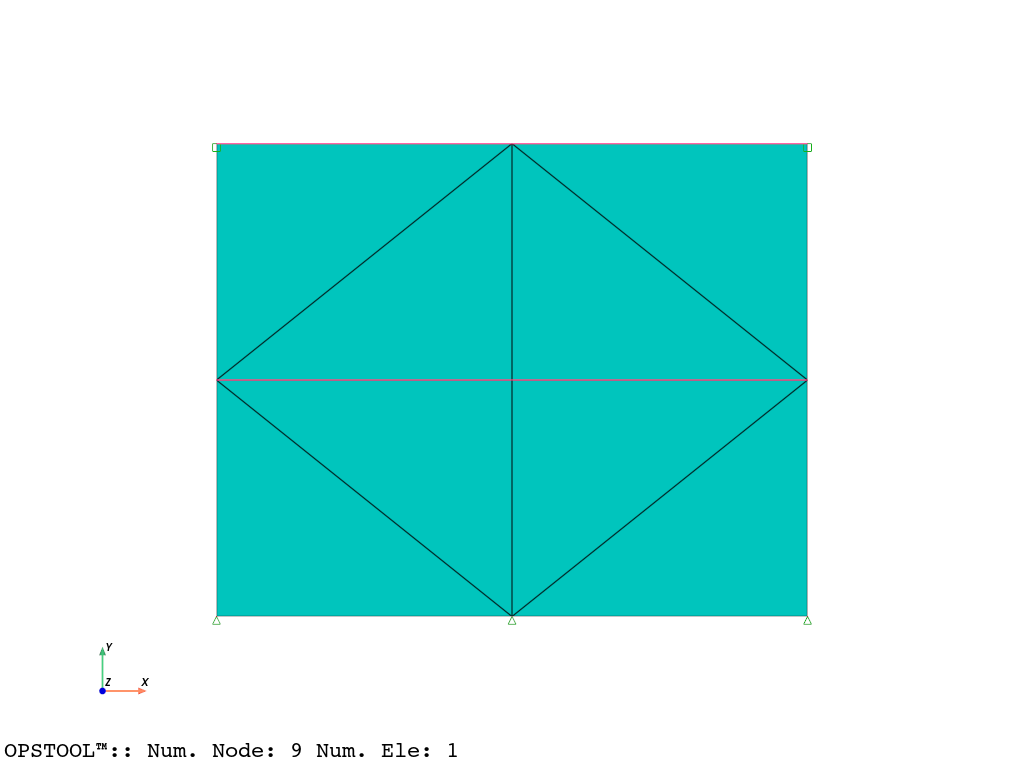

In [3]:
opsvis = opst.vis.pyvista

opsvis.set_plot_props(notebook=True)
fig = opsvis.plot_model()
fig.show(jupyter_backend="jupyterlab")

## GRAVITY APPLICATION (elastic behavior)

In [4]:
# create the SOE, ConstraintHandler, Integrator, Algorithm and Numberer
ops.updateMaterialStage("-material", 1, "-stage", 0)
ops.numberer("RCM")
ops.system("ProfileSPD")
ops.test("NormDispIncr", 1e-08, 30, 0)
ops.algorithm("KrylovNewton")
ops.constraints("Penalty", 1e18, 1e18)
ops.integrator("Newmark", 1.5, 1.0)
ops.analysis("Transient")
ops.analyze(10, 5000.0)
ops.updateMaterialStage("-material", 1, "-stage", 1)
ops.analyze(100, 1.0)

0

## APPLY LOADING SEQUENCE AND ANALYZE (plastic)

In [5]:
ops.wipeAnalysis()
ops.setTime(0.0)
ops.timeSeries("Trig", 1, 0.0, 10.0, 1.0, "-factor", 2)
ops.pattern("UniformExcitation", 1, 1, "-accel", 1)

In [6]:
ops.constraints("Penalty", 1e18, 1e18)
ops.test("NormDispIncr", 0.0001, 25, 0)
ops.numberer("RCM")
ops.algorithm("KrylovNewton")
ops.system("ProfileSPD")
ops.integrator("Newmark", 0.6, 0.30250000000000005)
ops.rayleigh(0.0, 0.0, 0.002, 0.0)
ops.analysis("Transient")

### Save the results

``compute_mechanical_measures`` is used to compute the mechanical measures, including various stress and strain measures.

``project_gauss_to_nodes`` is used to project the Gauss point results to the nodes.

* "copy": The response of each node is copied from the Gaussian point closest to it.
* "average": The response of each node is equal to the weighted average of the responses of all Gaussian points of the element, with the weight being the integration point weight.
* "extrapolate": The nodal responses are obtained by extrapolating the element shape functions.

In [7]:
ODB = opst.post.CreateODB(
    odb_tag=1,
    save_every=500,  # save every 500 steps, this will create (2500/500)=5 files
    compute_mechanical_measures=True,
    project_gauss_to_nodes="copy",  # "extrapolate", "copy", "average"
)
for _ in range(2500):
    ops.analyze(1, 0.01)
    ODB.fetch_response_step()
ODB.save_response()

OPSTOOL™ ::  All responses data with _odb_tag = 1 saved in 
g:\opstool\docs\src\post\.opstool.output\RespStepData-1.odb!

## Post-processing

### Nodal responses

In [8]:
node_resp = opst.post.get_nodal_responses(odb_tag=1)
print(node_resp)

OPSTOOL™ ::  Loading all response data from g:\opstool\docs\src\post\.opstool.output\RespStepData-1.odb ...

<xarray.Dataset> Size: 3MB
Dimensions:             (time: 2501, nodeTags: 9, DOFs: 6)
Coordinates:
  * time                (time) float32 10kB 0.0 0.01 0.02 ... 24.98 24.99 25.0
  * nodeTags            (nodeTags) int64 72B 1 2 3 4 5 6 7 8 9
  * DOFs                (DOFs) <U2 48B 'UX' 'UY' 'UZ' 'RX' 'RY' 'RZ'
Data variables:
    accel               (time, nodeTags, DOFs) float32 540kB 9.869e-31 ... 0.0
    disp                (time, nodeTags, DOFs) float32 540kB -9.002e-18 ... 0.0
    pressure            (time, nodeTags) float32 90kB 0.0 0.0 0.0 ... 0.0 0.0
    rayleighForces      (time, nodeTags, DOFs) float32 540kB -4.705e-14 ... 0.0
    reaction            (time, nodeTags, DOFs) float32 540kB 2.462 7.903 ... 0.0
    reactionIncInertia  (time, nodeTags, DOFs) float32 540kB 9.002 14.72 ... 0.0
    vel                 (time, nodeTags, DOFs) float32 540kB -2.544e-29 ... 0.0
Attributes:
    UX:       Displacement in X direction
    UY:       Displacement in Y direction
    UZ:       Displ

#### node 3 displacement relative to node 1

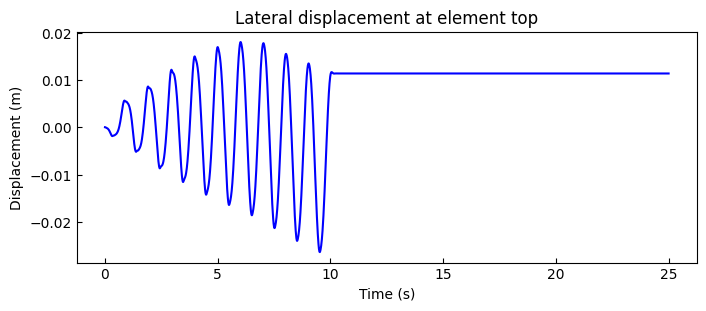

In [9]:
disp1 = node_resp["disp"].sel(nodeTags=1, DOFs="UX")
disp3 = node_resp["disp"].sel(nodeTags=3, DOFs="UX")
times = node_resp["time"].data

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(times, disp3 - disp1, "b")
ax.set_title("Lateral displacement at element top")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Displacement (m)")
plt.show()

#### node 3 acceleration

In [10]:
from scipy.interpolate import interp1d


t = np.linspace(0, 20 * np.pi, int(20 * np.pi / (np.pi / 50)) + 1)
s = 2 * np.sin(t)
s = np.concatenate((s, np.zeros(3000)))
x_original = np.linspace(0, 40, len(s))
interp_func = interp1d(x_original, s, kind="linear", fill_value="extrapolate")
s1 = interp_func(times)

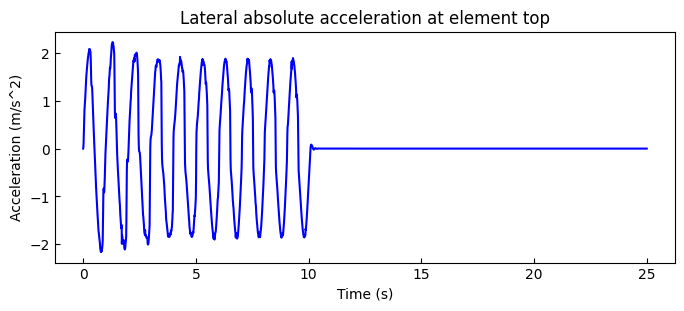

In [11]:
acc3 = node_resp["accel"].sel(nodeTags=3, DOFs="UX")
times = node_resp["time"].data

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(times, s1 + acc3, "b")
ax.set_title("Lateral absolute acceleration at element top")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Acceleration (m/s^2)")
plt.show()

#### Pore pressure at base

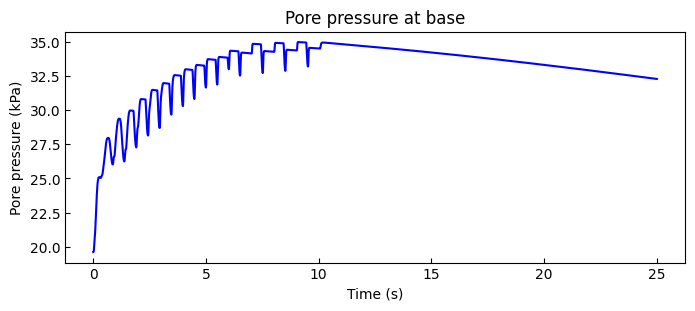

In [12]:
p1 = node_resp["vel"].sel(nodeTags=1, DOFs="RZ")  # pore pressure at node 1, stored in vel DOF "RZ"

fig, ax = plt.subplots(1, 1, figsize=(8, 3))

ax.plot(times, p1, "b")
ax.set_title("Pore pressure at base")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Pore pressure (kPa)")
plt.show()

### Elemental response

In [13]:
info = opst.post.get_element_responses_info(ele_type="Plane")

ele_type: Plane
Available Response Types (resp_type):
  - Stresses
    resp_dim: ['time', 'eleTags', 'GaussPoints', 'stressDOFs']
    resp_dof: ['sigma11', 'sigma22', 'sigma12', 'sigma33']
  - Strains
    resp_dim: ['time', 'eleTags', 'GaussPoints', 'strainDOFs']
    resp_dof: ['eps11', 'eps22', 'eps12']
  - StressesAtNodes
    resp_dim: ['time', 'nodeTags', 'stressDOFs']
    resp_dof: ['sigma11', 'sigma22', 'sigma12', 'sigma33']
  - StressAtNodesErr
    resp_dim: ['time', 'nodeTags', 'stressDOFs']
    resp_dof: ['sigma11', 'sigma22', 'sigma12', 'sigma33']
  - StrainsAtNodes
    resp_dim: ['time', 'nodeTags', 'strainDOFs']
    resp_dof: ['eps11', 'eps22', 'eps12']
  - StrainsAtNodesErr
    resp_dim: ['time', 'nodeTags', 'strainDOFs']
    resp_dof: ['eps11', 'eps22', 'eps12']
  - PorePressureAtNodes
    resp_dim: ['time', 'nodeTags']
    resp_dof: None



In [14]:
ele_resp = opst.post.get_element_responses(odb_tag=1, ele_type="Plane")

OPSTOOL™ ::  Loading Plane response data from g:\opstool\docs\src\post\.opstool.output\RespStepData-1.odb ...

In [15]:
print("Data Variables in Element Responses:", ele_resp.data_vars)

Data Variables in Element Responses: Data variables:
    PorePressureAtNodes    (time, nodeTags) float64 180kB 19.62 19.62 ... 0.0
    Strains                (time, eleTags, GaussPoints, strainDOFs) float32 270kB ...
    StrainsAtNodes         (time, nodeTags, strainDOFs) float32 270kB 1.229e-...
    StrainsAtNodesErr      (time, nodeTags, strainDOFs) float32 270kB 0.0 ......
    StressAtNodesErr       (time, nodeTags, stressDOFs) float32 450kB 0.0 ......
    Stresses               (time, eleTags, GaussPoints, stressDOFs) float32 450kB ...
    StressesAtNodes        (time, nodeTags, stressDOFs) float32 450kB -6.554 ...
    StressMeasures         (time, eleTags, GaussPoints, measures) float32 720kB ...
    StressMeasuresAtNodes  (time, nodeTags, measures) float32 720kB -6.554 .....


In [16]:
print(ele_resp.coords)

Coordinates:
  * time         (time) float32 10kB 0.0 0.01 0.02 0.03 ... 24.98 24.99 25.0
  * nodeTags     (nodeTags) int64 72B 1 2 3 4 5 6 7 8 9
  * eleTags      (eleTags) int64 8B 1
  * GaussPoints  (GaussPoints) int64 72B 1 2 3 4 5 6 7 8 9
  * strainDOFs   (strainDOFs) <U5 60B 'eps11' 'eps22' 'eps12'
  * stressDOFs   (stressDOFs) <U7 140B 'sigma11' 'sigma22' ... 'para#1'
  * measures     (measures) <U9 288B 'p1' 'p2' 'p3' ... 'tau_oct' 'tau_max'


In [17]:
for key, value in ele_resp.attrs.items():
    print(f"{key}: {value}")

sigma11, sigma22, sigma12: Normal stress and shear stress in the x-y plane.
sigma33: Out-of-plane normal stress.
para#i: The additional output of stress, which is useful for some elements, such as * eta_r * for some u-p elements. eta_r--Ratio between the shear (deviatoric) stress and peak shear strength at the current confinement.
p1, p2, p3: Principal stresses, p3=0 for 2D plane stress condition, p3!=0 for 3D plane strain condition.
theta: Angle (degrees) between x-axis and principal axis 1.
sigma_vm: Von Mises stress.
tau_max: Maximum shear stress, 0.5*(p1-p3).
sigma_oct: Octahedral normal stress, (p1+p2+p3)/3.
tau_oct: Octahedral shear stress, sqrt(2/3*J2).
sigma_mohr_coulomb_sy_eq: Mohr-Coulomb equivalent stress (using tensile and compressive strengths).
sigma_mohr_coulomb_sy_intensity: Mohr-Coulomb intensity (using tensile and compressive strengths).
sigma_mohr_coulomb_c_phi_eq: Mohr-Coulomb equivalent stress (using cohesion and friction angle).
sigma_mohr_coulomb_c_phi_intensity:

#### Gauss point responses

Extract the stresses of element 1

In [18]:
sigma11 = ele_resp["Stresses"].sel(stressDOFs="sigma11", eleTags=1)
sigma22 = ele_resp["Stresses"].sel(stressDOFs="sigma22", eleTags=1)
sigma33 = ele_resp["Stresses"].sel(stressDOFs="sigma33", eleTags=1)
sigma12 = ele_resp["Stresses"].sel(stressDOFs="sigma12", eleTags=1)
eta_r = ele_resp["Stresses"].sel(stressDOFs="para#1", eleTags=1)

Calculate confinement p and deviatoric stress q

In [19]:
po = ele_resp["StressMeasures"].sel(measures="sigma_oct", eleTags=1)
tau_oct = ele_resp["StressMeasures"].sel(measures="tau_oct", eleTags=1)
qo = tau_oct
print(qo)

<xarray.DataArray 'StressMeasures' (time: 2501, GaussPoints: 9)> Size: 90kB
array([[3.4757295 , 3.4757295 , 0.44147557, ..., 0.44147557, 1.9586025 ,
        1.9586025 ],
       [3.4746077 , 3.4746077 , 0.44140658, ..., 0.44140658, 1.9582564 ,
        1.9582564 ],
       [3.4695098 , 3.4695098 , 0.4401557 , ..., 0.4401557 , 1.9558568 ,
        1.9558568 ],
       ...,
       [0.50430477, 0.50430477, 0.07051353, ..., 0.07051353, 0.27091134,
        0.27091134],
       [0.50470805, 0.50470805, 0.0705704 , ..., 0.0705704 , 0.271121  ,
        0.271121  ],
       [0.50511146, 0.50511146, 0.07062731, ..., 0.07062731, 0.27133083,
        0.27133083]], shape=(2501, 9), dtype=float32)
Coordinates:
  * time         (time) float32 10kB 0.0 0.01 0.02 0.03 ... 24.98 24.99 25.0
  * GaussPoints  (GaussPoints) int64 72B 1 2 3 4 5 6 7 8 9
    eleTags      int64 8B 1
    measures     <U9 36B 'tau_oct'


Extract the strains of element 1

In [20]:
eps11 = ele_resp["Strains"].sel(strainDOFs="eps11", eleTags=1)
eps22 = ele_resp["Strains"].sel(strainDOFs="eps22", eleTags=1)
eps12 = ele_resp["Strains"].sel(strainDOFs="eps12", eleTags=1)

#### integration point 1 p-q

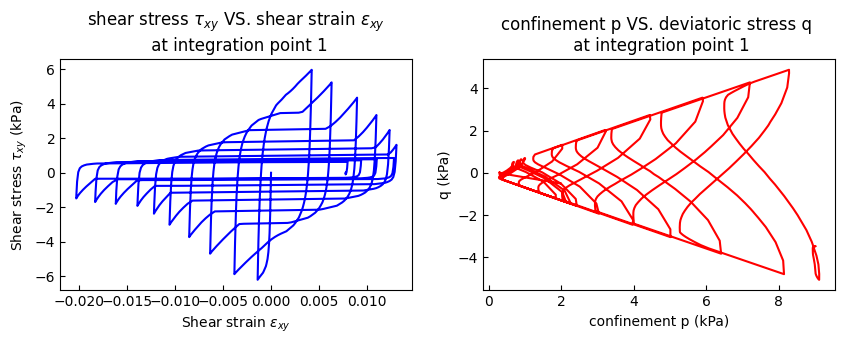

In [21]:
eps12_ele1_1 = eps12.sel(GaussPoints=1)
sigma12_ele1_1 = sigma12.sel(GaussPoints=1)
po_ele1_1 = po.sel(GaussPoints=1)
qo_ele1_1 = qo.sel(GaussPoints=1) * np.sign(sigma12_ele1_1)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(eps12_ele1_1, sigma12_ele1_1, "b")
axs[0].set_title("shear stress $\\tau_{xy}$ VS. shear strain $\\epsilon_{xy}$ \n at integration point 1")
axs[0].set_xlabel(r"Shear strain $\epsilon_{xy}$")
axs[0].set_ylabel(r"Shear stress $\tau_{xy}$ (kPa)")
axs[1].plot(-po_ele1_1, qo_ele1_1, "r")
axs[1].set_title("confinement p VS. deviatoric stress q \n at integration point 1")
axs[1].set_xlabel("confinement p (kPa)")
axs[1].set_ylabel("q (kPa)")
plt.show()

#### integration point 5 p-q

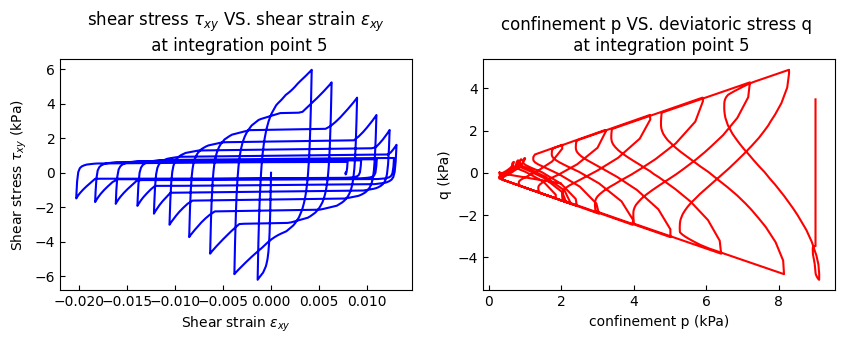

In [22]:
eps12_ele1_5 = eps12.sel(GaussPoints=5)
sigma12_ele1_5 = sigma12.sel(GaussPoints=5)
po_ele1_5 = po.sel(GaussPoints=5)
qo_ele1_5 = qo.sel(GaussPoints=5) * np.sign(sigma12_ele1_5)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(eps12_ele1_5, sigma12_ele1_5, "b")
axs[0].set_title("shear stress $\\tau_{xy}$ VS. shear strain $\\epsilon_{xy}$ \n at integration point 5")
axs[0].set_xlabel(r"Shear strain $\epsilon_{xy}$")
axs[0].set_ylabel(r"Shear stress $\tau_{xy}$ (kPa)")
axs[1].plot(-po_ele1_5, qo_ele1_5, "r")
axs[1].set_title("confinement p VS. deviatoric stress q \n at integration point 5")
axs[1].set_xlabel("confinement p (kPa)")
axs[1].set_ylabel("q (kPa)")
plt.show()

#### integration point 9 p-q

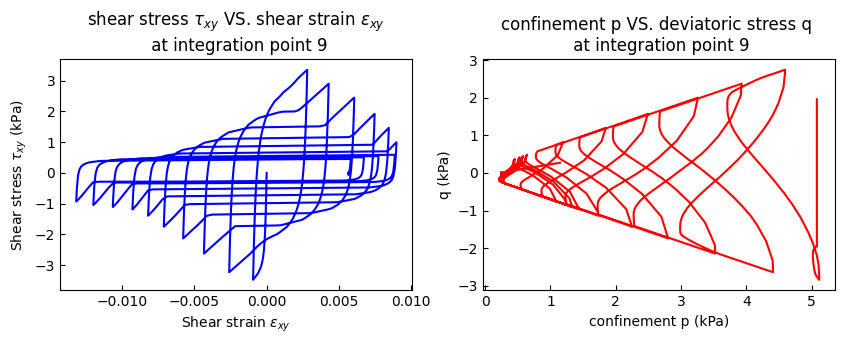

In [23]:
eps12_ele1_9 = eps12.sel(GaussPoints=9)
sigma12_ele1_9 = sigma12.sel(GaussPoints=9)
po_ele1_9 = po.sel(GaussPoints=9)
qo_ele1_9 = qo.sel(GaussPoints=9) * np.sign(sigma12_ele1_9)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(eps12_ele1_9, sigma12_ele1_9, "b")
axs[0].set_title("shear stress $\\tau_{xy}$ VS. shear strain $\\epsilon_{xy}$ \n at integration point 9")
axs[0].set_xlabel(r"Shear strain $\epsilon_{xy}$")
axs[0].set_ylabel(r"Shear stress $\tau_{xy}$ (kPa)")
axs[1].plot(-po_ele1_9, qo_ele1_9, "r")
axs[1].set_title("confinement p VS. deviatoric stress q \n at integration point 9")
axs[1].set_xlabel("confinement p (kPa)")
axs[1].set_ylabel("q (kPa)")
plt.show()

#### Nodal Stresses

In [24]:
print("Dimensions:", ele_resp["StressesAtNodes"].dims)
print("Coords: ", ele_resp["StressesAtNodes"].coords)

Dimensions: ('time', 'nodeTags', 'stressDOFs')
Coords:  Coordinates:
  * time        (time) float32 10kB 0.0 0.01 0.02 0.03 ... 24.98 24.99 25.0
  * nodeTags    (nodeTags) int64 72B 1 2 3 4 5 6 7 8 9
  * stressDOFs  (stressDOFs) <U7 140B 'sigma11' 'sigma22' ... 'sigma33' 'para#1'


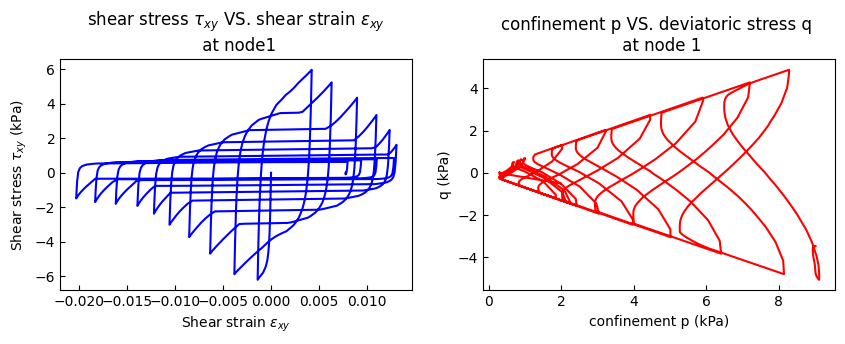

In [25]:
sxy5 = ele_resp["StressesAtNodes"].sel(stressDOFs="sigma12", nodeTags=1)
exy5 = ele_resp["StrainsAtNodes"].sel(strainDOFs="eps12", nodeTags=1)

p5 = ele_resp["StressMeasuresAtNodes"].sel(measures="sigma_oct", nodeTags=1)
q5 = ele_resp["StressMeasuresAtNodes"].sel(measures="tau_oct", nodeTags=1)
q5 = q5 * np.sign(sxy5)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(exy5, sxy5, "b")
axs[0].set_title("shear stress $\\tau_{xy}$ VS. shear strain $\\epsilon_{xy}$ \n at node1")
axs[0].set_xlabel(r"Shear strain $\epsilon_{xy}$")
axs[0].set_ylabel(r"Shear stress $\tau_{xy}$ (kPa)")
axs[1].plot(-p5, q5, "r")
axs[1].set_title("confinement p VS. deviatoric stress q \n at node 1")
axs[1].set_xlabel("confinement p (kPa)")
axs[1].set_ylabel("q (kPa)")
plt.show()

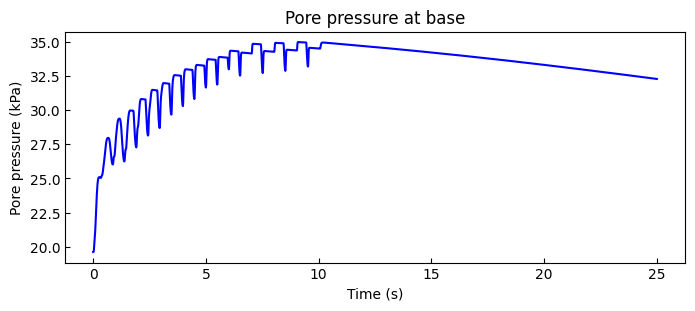

In [26]:
p1 = ele_resp["PorePressureAtNodes"].sel(nodeTags=1)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))

ax.plot(times, p1, "b")
ax.set_title("Pore pressure at base")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Pore pressure (kPa)")
plt.show()